Dataset shape: (4945, 13)
Columns: ['type', 'release_date', 'process_size_(nm)', 'tdp_(w)', 'die_size_(mm^2)', 'transistors_(million)', 'freq_(ghz)', 'foundry', 'vendor', 'fp16_gflops', 'fp32_gflops', 'fp64_gflops', 'year']

First rows:
   type release_date process_size_(nm)  tdp_(w) die_size_(mm^2)  \
0  GPU   1999-03-15               250  unknown              63   
1  CPU   2000-01-12               180       25             106   
2  CPU   2000-01-12               180       25             106   
3  GPU   2000-03-01               250  unknown              63   
4  GPU   2000-03-04               250  unknown             279   

  transistors_(million)  freq_(ghz) foundry  vendor   fp16_gflops  \
0                    15  1615.43079    TSMC  NVIDIA  19033.061063   
1                    28   800.00000   Intel   Intel  19033.061063   
2                    28   800.00000   Intel   Intel  19033.061063   
3                    15   105.00000    TSMC  NVIDIA  19033.061063   
4                   

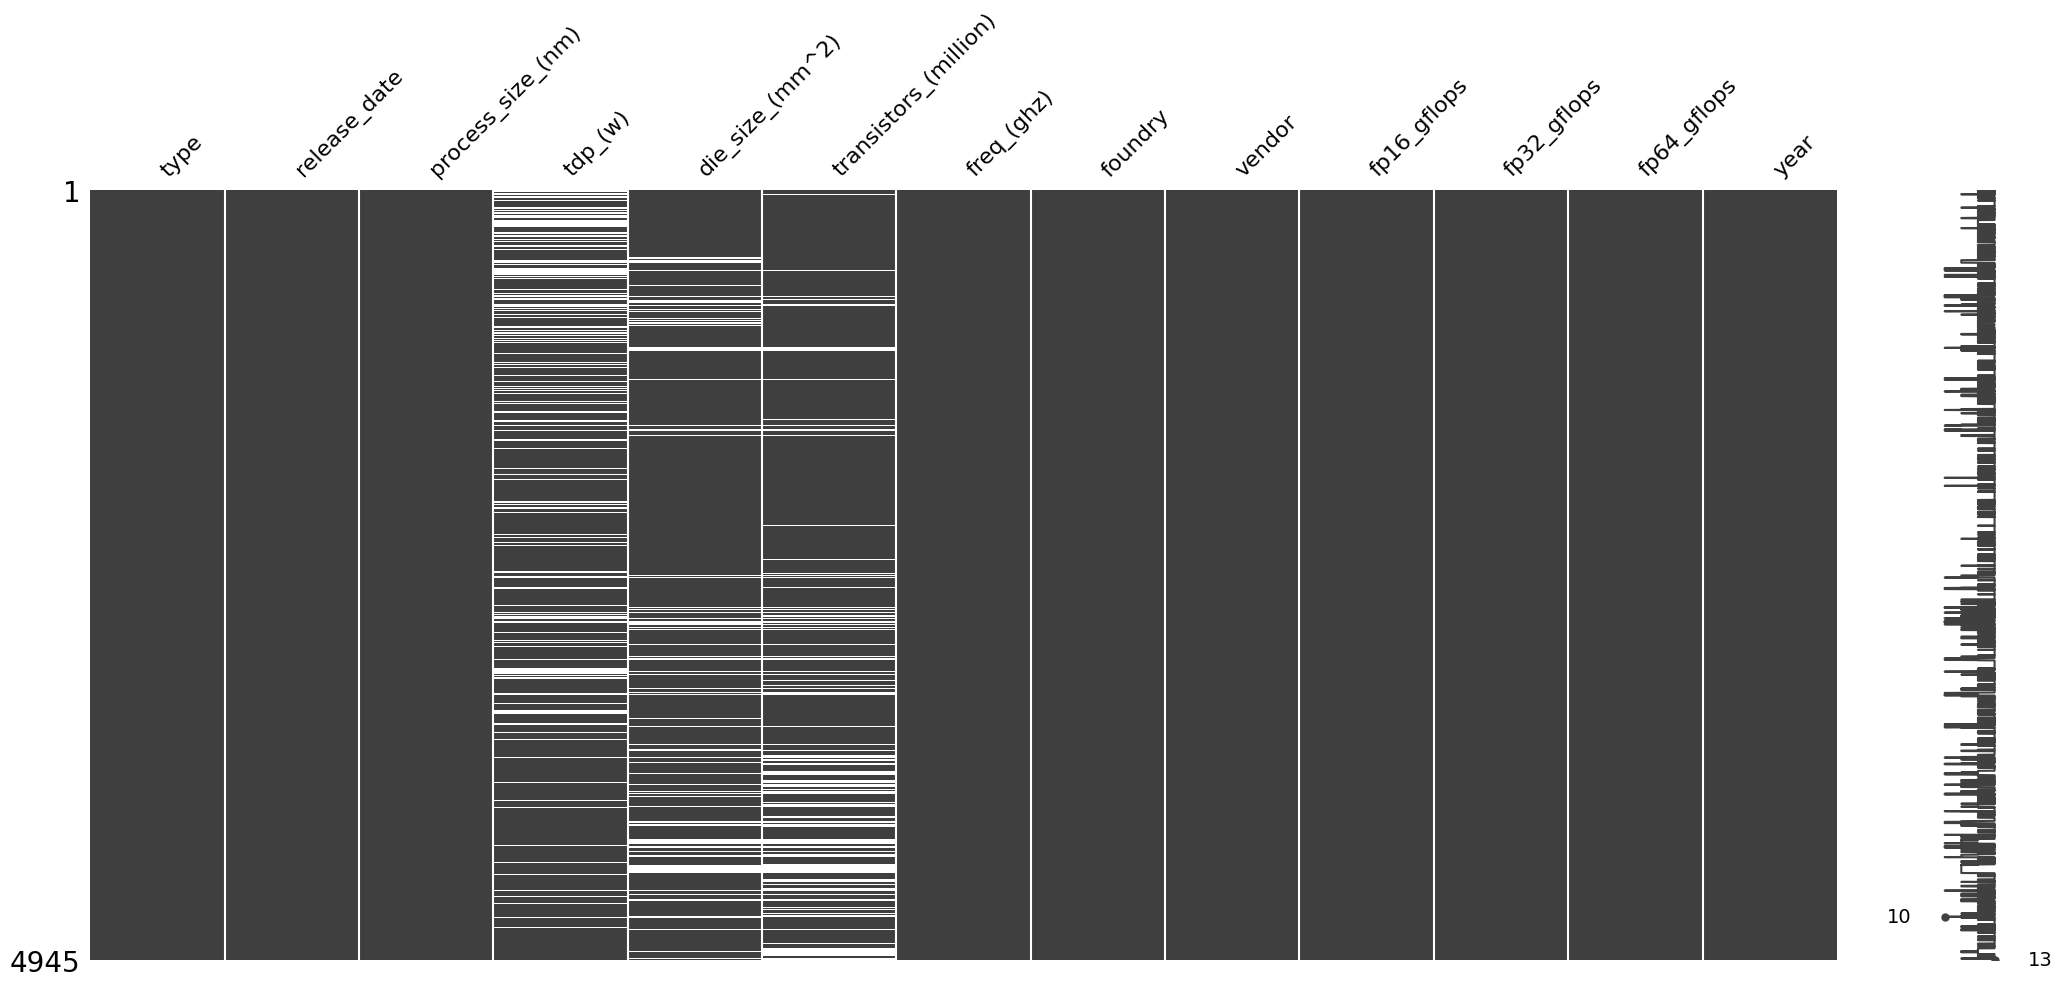

Missing values after cleaning:
 type                     0
release_date             0
process_size_(nm)        0
tdp_(w)                  0
die_size_(mm^2)          0
transistors_(million)    0
freq_(ghz)               0
foundry                  0
vendor                   0
fp16_gflops              0
fp32_gflops              0
fp64_gflops              0
year                     0
dtype: int64


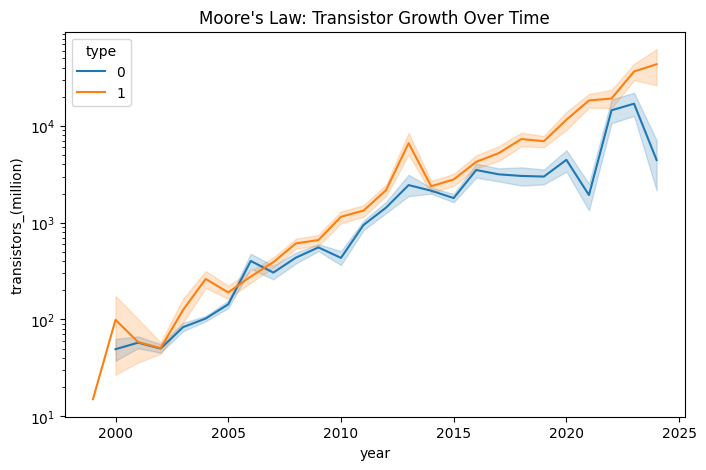

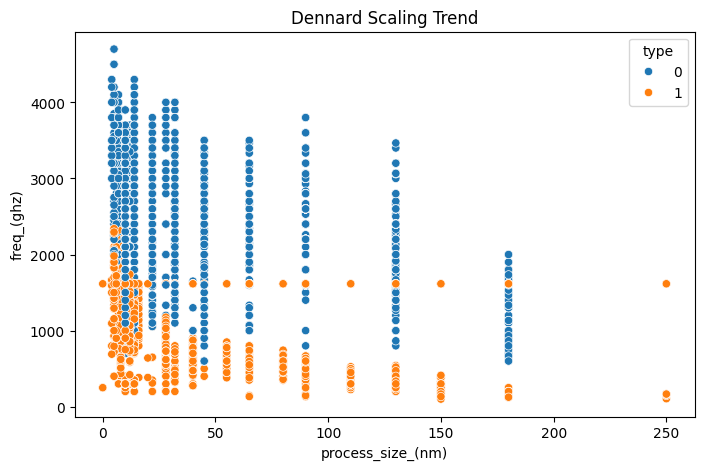

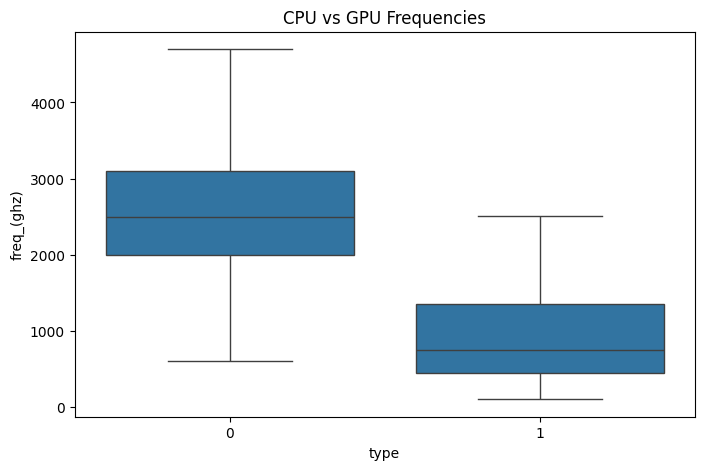

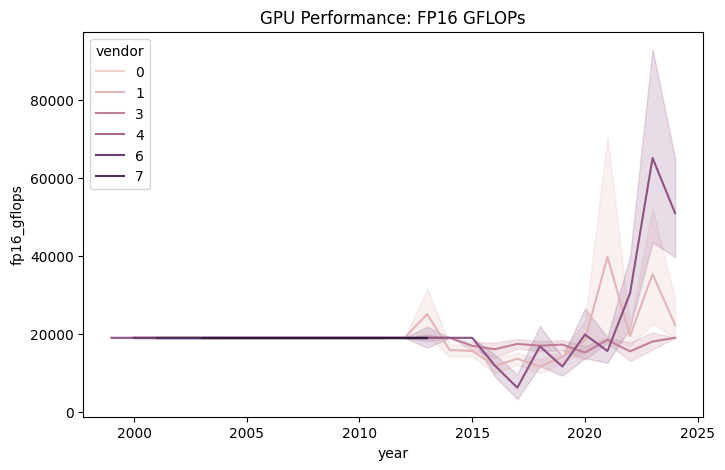

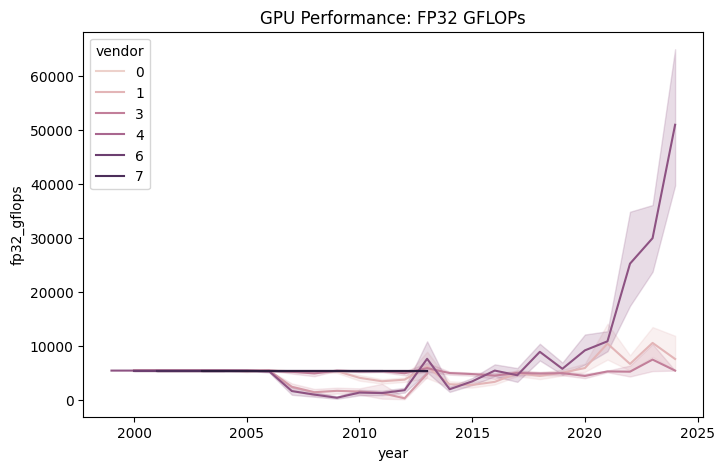

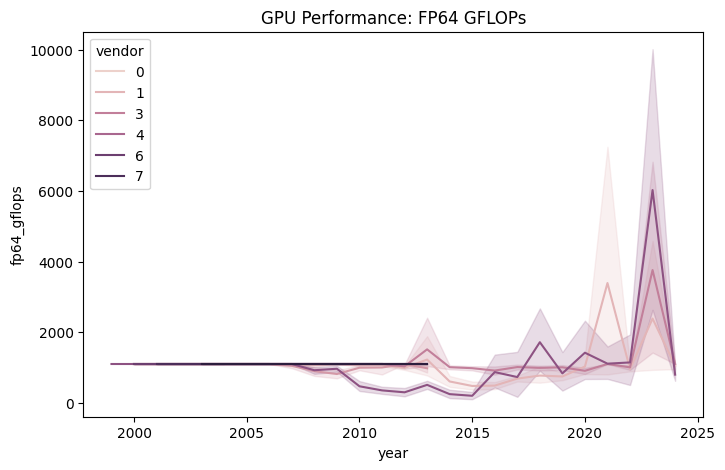

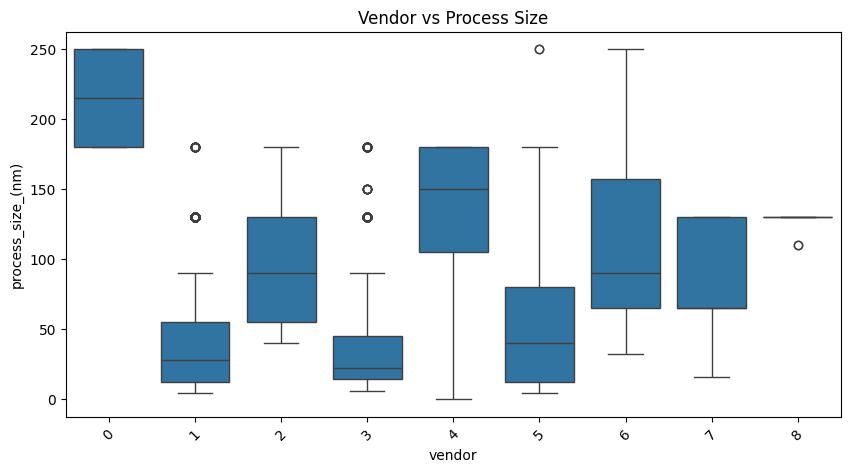

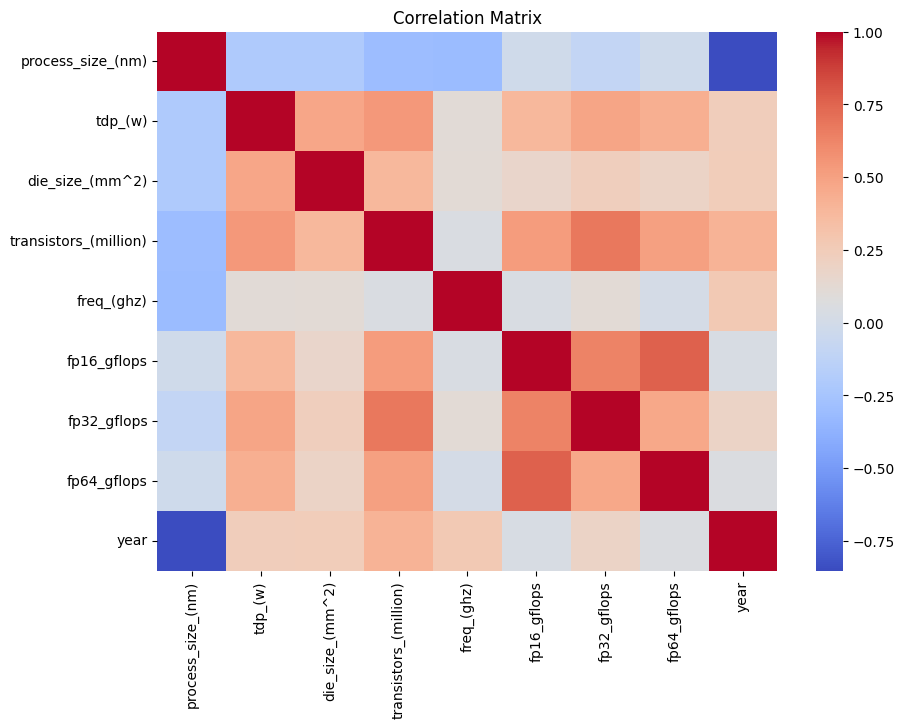


--- Model Evaluation ---
R² Score: 0.1347471578147047
MAE: 850.7486220442105
RMSE: 979.6211663302668

✅ Full analysis + ML complete! Plots saved in: outputs/plots


In [ ]:
# Semiconductor_data project
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


cleaned_path = "./outputs/chip_dataset_cleaned.csv"
df = pd.read_csv(cleaned_path)

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst rows:\n", df.head())
print("\nInfo:\n")
print(df.info())
print("\nDescription:\n", df.describe())


def clean_numeric_column(series):
    """Remove non-numeric characters and convert to float"""
    return pd.to_numeric(
        series.astype(str).str.replace(r'[^0-9\.]', '', regex=True),
        errors="coerce"
    )

numeric_like_cols = [
    "process_size_(nm)", "tdp_(w)", "die_size_(mm^2)",
    "transistors_(million)", "freq_(ghz)",
    "fp16_gflops", "fp32_gflops", "fp64_gflops"
]

for col in numeric_like_cols:
    if col in df.columns:
        df[col] = clean_numeric_column(df[col])

msno.matrix(df)
plt.show()

numeric_cols = df.select_dtypes(include="number").columns
categorical_cols = df.select_dtypes(exclude="number").columns


imputer = SimpleImputer(strategy="median")
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])


for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")


le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

print("Missing values after cleaning:\n", df.isna().sum())

if "transistors_(million)" in df.columns and "die_size_(mm^2)" in df.columns:
    df["transistor_density"] = df["transistors_(million)"] / (df["die_size_(mm^2)"] + 1e-6)

# Save cleaned dataset again
os.makedirs("outputs", exist_ok=True)
df.to_csv("./outputs/chip_dataset_final.csv", index=False)

# Visualizations

output_dir = "outputs/plots"
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="year", y="transistors_(million)", hue="type")
plt.yscale("log")
plt.title("Moore's Law: Transistor Growth Over Time")
plt.savefig(os.path.join(output_dir, "moores_law.png"))
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="process_size_(nm)", y="freq_(ghz)", hue="type")
plt.title("Dennard Scaling Trend")
plt.savefig(os.path.join(output_dir, "dennard_scaling.png"))
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="type", y="freq_(ghz)")
plt.title("CPU vs GPU Frequencies")
plt.savefig(os.path.join(output_dir, "cpu_gpu_frequencies.png"))
plt.show()

plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="year", y="fp16_gflops", hue="vendor")
plt.title("GPU Performance: FP16 GFLOPs")
plt.savefig(os.path.join(output_dir, "gpu_perf_fp16_gflops.png"))
plt.show()

plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="year", y="fp32_gflops", hue="vendor")
plt.title("GPU Performance: FP32 GFLOPs")
plt.savefig(os.path.join(output_dir, "gpu_perf_fp32_gflops.png"))
plt.show()

plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="year", y="fp64_gflops", hue="vendor")
plt.title("GPU Performance: FP64 GFLOPs")
plt.savefig(os.path.join(output_dir, "gpu_perf_fp64_gflops.png"))
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="vendor", y="process_size_(nm)")
plt.xticks(rotation=45)
plt.title("Vendor vs Process Size")
plt.savefig(os.path.join(output_dir, "vendor_process_size.png"))
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(df[numeric_cols].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.savefig(os.path.join(output_dir, "correlation_matrix.png"))
plt.show()


# Predicting  frequency from other features
target = "freq_(ghz)"
features = [col for col in numeric_cols if col != target]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\n--- Model Evaluation ---")
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

print("\n Full analysis + ML complete! Plots saved in:", output_dir)
